## Import modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from prophet import Prophet

In [2]:
# Clean up just in case
!pip uninstall -y fbprophet
!pip install -q cmdstanpy
!pip install -q prophet


ERROR: Operation cancelled by user


## Loading the dataset

In [3]:
df = pd.read_csv('Traffic data.csv')
df.head()

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


In [ ]:
df

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2
...,...,...,...
18283,18283,25-09-2014 19:00,868
18284,18284,25-09-2014 20:00,732
18285,18285,25-09-2014 21:00,702
18286,18286,25-09-2014 22:00,580


## Preprocessing the dataset

In [4]:
# check null values
df.isnull().sum()

,0
ID,0
Datetime,0
Count,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18288 entries, 0 to 18287
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        18288 non-null  int64 
 1   Datetime  18288 non-null  object
 2   Count     18288 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 428.8+ KB


In [6]:
# convert object to datetime datatype
df['Datetime'] = pd.to_datetime(df['Datetime'], format='%d-%m-%Y %H:%M')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18288 entries, 0 to 18287
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ID        18288 non-null  int64         
 1   Datetime  18288 non-null  datetime64[ns]
 2   Count     18288 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 428.8 KB


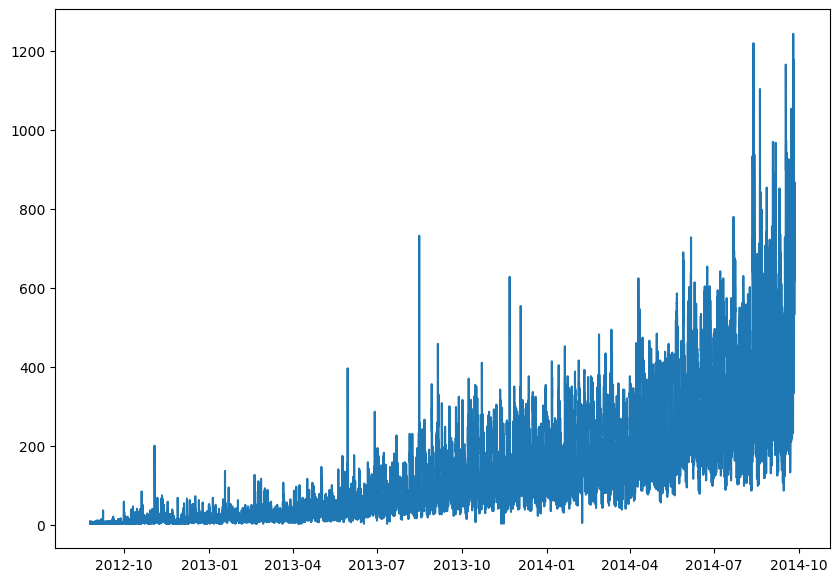

In [7]:
# EDA
plt.figure(figsize=(10,7))
plt.plot(df['Datetime'], df['Count'])
plt.show()

## Format data for the model

In [8]:
df.index = df['Datetime']
df['y'] = df['Count']
df.drop(columns=['ID', 'Datetime', 'Count'], axis=1, inplace=True)
df = df.resample('D').sum()
df.head()

,y
Datetime,
2012-08-25,76
2012-08-26,88
2012-08-27,62
2012-08-28,58
2012-08-29,60


In [9]:
df['ds'] = df.index
df.head()

,y,ds
Datetime,,
2012-08-25,76,2012-08-25
2012-08-26,88,2012-08-26
2012-08-27,62,2012-08-27
2012-08-28,58,2012-08-28
2012-08-29,60,2012-08-29


## Input Split

In [10]:
size = 60
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=size/len(df), shuffle=False)

In [11]:
train.tail()

,y,ds
Datetime,,
2014-07-23,10130,2014-07-23
2014-07-24,8156,2014-07-24
2014-07-25,7192,2014-07-25
2014-07-26,6562,2014-07-26
2014-07-27,6094,2014-07-27


In [12]:
test.head()

,y,ds
Datetime,,
2014-07-28,8546,2014-07-28
2014-07-29,8218,2014-07-29
2014-07-30,8498,2014-07-30
2014-07-31,8740,2014-07-31
2014-08-01,9186,2014-08-01


In [13]:
test.tail()

,y,ds
Datetime,,
2014-09-21,9102,2014-09-21
2014-09-22,14116,2014-09-22
2014-09-23,13304,2014-09-23
2014-09-24,16856,2014-09-24
2014-09-25,14152,2014-09-25


## Model Training

In [14]:
model = Prophet(yearly_seasonality=True, seasonality_prior_scale=0.9)
model.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf92klq_g/f7unvh0w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf92klq_g/mbmf323c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59447', 'data', 'file=/tmp/tmpf92klq_g/f7unvh0w.json', 'init=/tmp/tmpf92klq_g/mbmf323c.json', 'output', 'file=/tmp/tmpf92klq_g/prophet_modeln78sbl35/prophet_model-20250417163325.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:33:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:33:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [15]:
future = model.make_future_dataframe(periods=60)
future

,ds
0,2012-08-25
1,2012-08-26
2,2012-08-27
3,2012-08-28
4,2012-08-29
...,...
757,2014-09-21
758,2014-09-22
759,2014-09-23
760,2014-09-24


In [16]:
forecast = model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-08-25,-480.549353,-1791.060282,117.174502,-480.549353,-480.549353,-339.799474,-339.799474,-339.799474,-846.222509,-846.222509,-846.222509,506.423035,506.423035,506.423035,0.0,0.0,0.0,-820.348827
1,2012-08-26,-473.533148,-1905.695502,98.066751,-473.533148,-473.533148,-455.655503,-455.655503,-455.655503,-967.194811,-967.194811,-967.194811,511.539308,511.539308,511.539308,0.0,0.0,0.0,-929.188651
2,2012-08-27,-466.516944,-518.993727,1418.880050,-466.516944,-466.516944,946.386736,946.386736,946.386736,431.219381,431.219381,431.219381,515.167355,515.167355,515.167355,0.0,0.0,0.0,479.869792
3,2012-08-28,-459.500739,-449.755605,1461.157522,-459.500739,-459.500739,957.005846,957.005846,957.005846,439.583977,439.583977,439.583977,517.421870,517.421870,517.421870,0.0,0.0,0.0,497.505107
4,2012-08-29,-452.484535,-512.758115,1453.395727,-452.484535,-452.484535,918.200812,918.200812,918.200812,399.776600,399.776600,399.776600,518.424212,518.424212,518.424212,0.0,0.0,0.0,465.716277


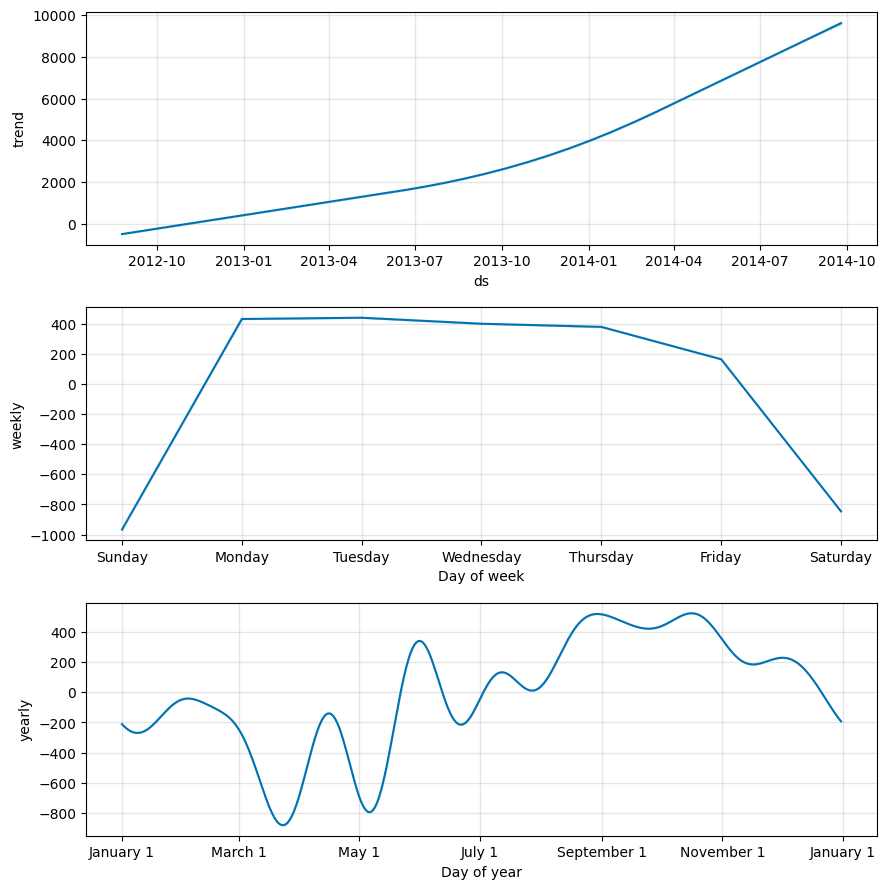

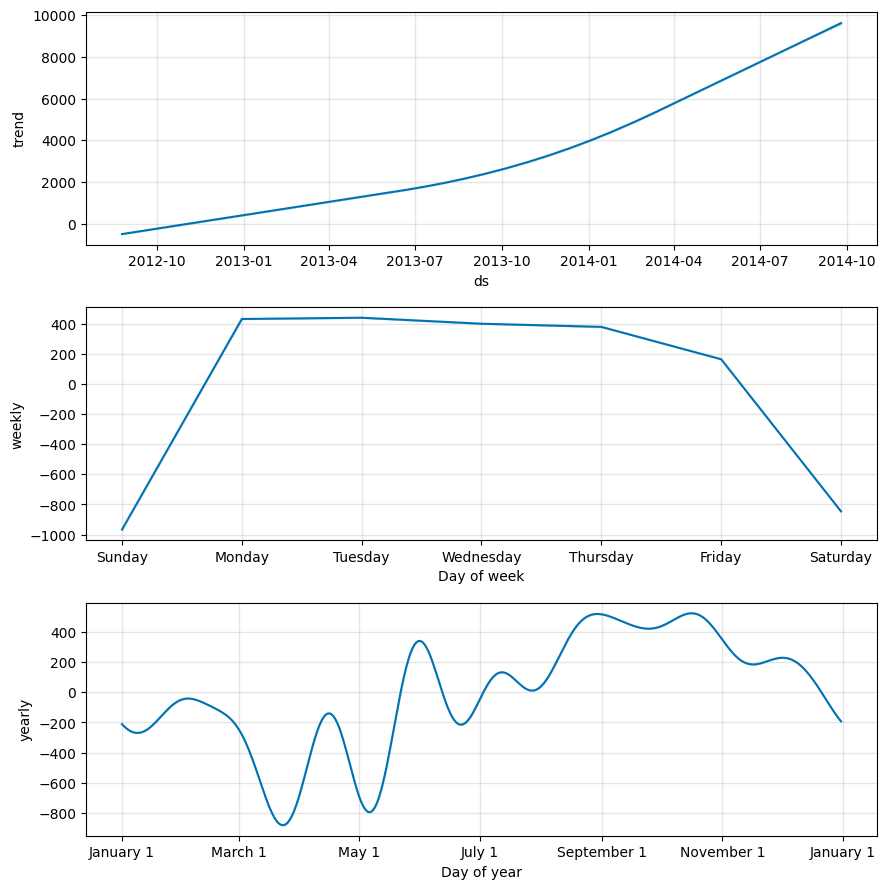

In [17]:
model.plot_components(forecast)

In [18]:
pred = forecast.iloc[-60:, :]
len(pred)

60

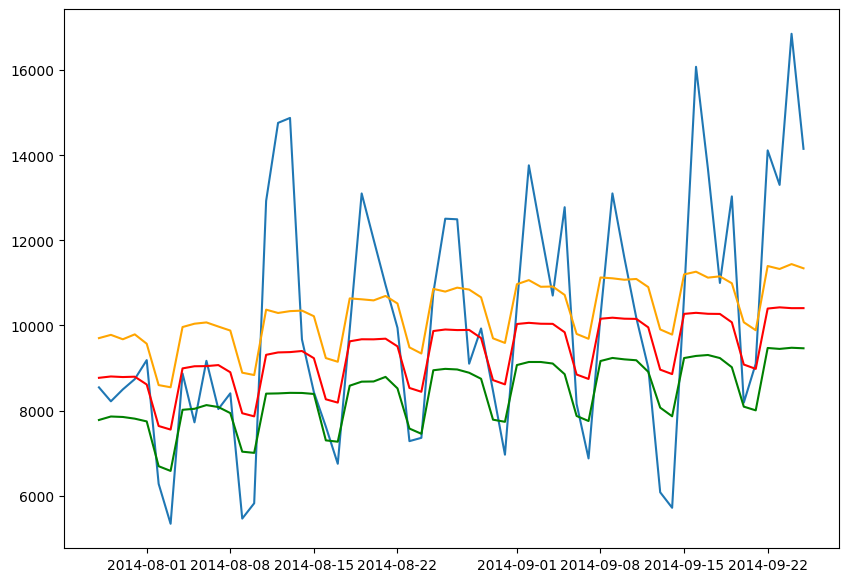

In [19]:
# test results
plt.figure(figsize=(10,7))
plt.plot(test['ds'], test['y'])
plt.plot(pred['ds'], pred['yhat'], color='red')
plt.plot(pred['ds'], pred['yhat_lower'], color='green')
plt.plot(pred['ds'], pred['yhat_upper'], color='orange')
plt.show()

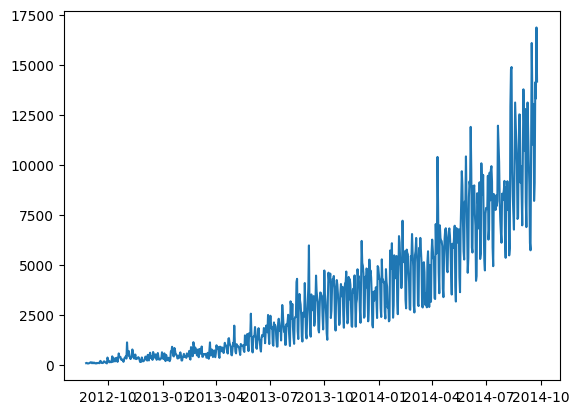

In [20]:
# input data
plt.plot(df['ds'], df['y'])
plt.show()

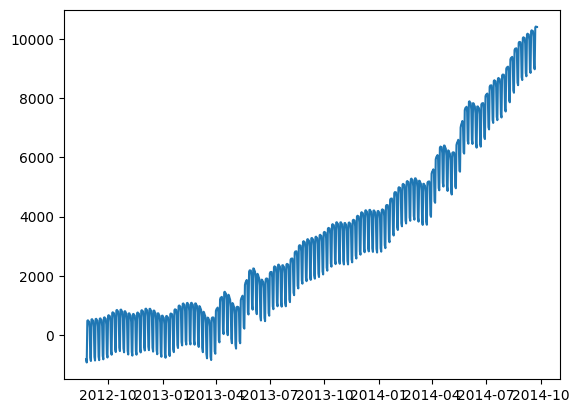

In [21]:
# forecast data
plt.plot(forecast['ds'], forecast['yhat'])
plt.show()

In [22]:
model = Prophet(yearly_seasonality=True, seasonality_prior_scale=0.9)
model.fit(df)
future = model.make_future_dataframe(periods=200)
forecast = model.predict(future)
forecast.head()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf92klq_g/ovqhgyb3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf92klq_g/2aqy_91f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74069', 'data', 'file=/tmp/tmpf92klq_g/ovqhgyb3.json', 'init=/tmp/tmpf92klq_g/2aqy_91f.json', 'output', 'file=/tmp/tmpf92klq_g/prophet_modelp98f3mt6/prophet_model-20250417163342.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:33:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:33:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-08-25,-676.301489,-2228.824476,81.724211,-676.301489,-676.301489,-422.335565,-422.335565,-422.335565,-995.253546,-995.253546,-995.253546,572.917981,572.917981,572.917981,0.0,0.0,0.0,-1098.637054
1,2012-08-26,-668.253402,-2364.482351,-31.063780,-668.253402,-668.253402,-580.698066,-580.698066,-580.698066,-1144.312380,-1144.312380,-1144.312380,563.614315,563.614315,563.614315,0.0,0.0,0.0,-1248.951468
2,2012-08-27,-660.205316,-913.481662,1577.817781,-660.205316,-660.205316,1009.048146,1009.048146,1009.048146,457.597071,457.597071,457.597071,551.451075,551.451075,551.451075,0.0,0.0,0.0,348.842830
3,2012-08-28,-652.157229,-721.780195,1608.978170,-652.157229,-652.157229,1145.642242,1145.642242,1145.642242,608.400404,608.400404,608.400404,537.241838,537.241838,537.241838,0.0,0.0,0.0,493.485013
4,2012-08-29,-644.109142,-696.915944,1672.018586,-644.109142,-644.109142,1078.767522,1078.767522,1078.767522,556.948562,556.948562,556.948562,521.818959,521.818959,521.818959,0.0,0.0,0.0,434.658379


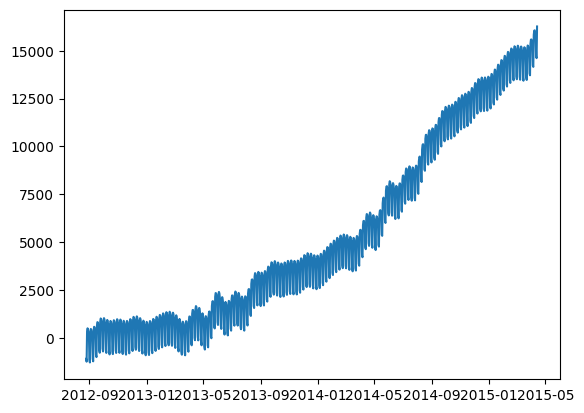

In [23]:
# forecast data
plt.plot(forecast['ds'], forecast['yhat'])
plt.show()